In [ ]:
import cv2

import pytesseract # add tesseract to your path
import easyocr

import os
import numpy as np
from matplotlib import pyplot as plt

from skimage import io
from skimage.color import rgb2gray
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin
from skimage.measure import find_contours
from skimage.draw import rectangle

from skimage.transform import rotate;
from scipy.signal import find_peaks;
import cv2;
import math;

from skimage.segmentation import flood_fill;
from commonfunctions import *

import imutils

# Show the figures / plots inside the notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2


##### Functions that Check if Plate 

In [111]:
def checkIfPlate(contour, img):

    minRatio = 2.3
    maxRatio = 8

    height, width, _ = img.shape 
    area = height * width
    
    minArea = 0.01 * area
    maxArea = 0.25 * area
    
    x,y,w,h = cv2.boundingRect(contour)  
    contourArea = w*h

    # print(f'minRation:${minRatio}, w/h:{w/h}, maxRation:{maxRatio}')
    # print(f'minArea:${minArea}, contourArea:{contourArea}, maxArea:{maxArea}')

    if (w/h >  minRatio and  w/h <maxRatio and contourArea > minArea and  contourArea < maxArea ):
        return True
    return False



In [ ]:
def checkIfPlate1(contour, img):
    
    minRatio = 2.3
    maxRatio = 5

    height, width, _ = img.shape 
    area = height * width
    
    minArea = 0.01 * area
    maxArea = 0.25 * area
    
    x,y,w,h = cv2.boundingRect(contour)  
    contourArea = w*h

    if (w/h >  minRatio and  w/h <maxRatio and contourArea > minArea and  contourArea < maxArea ):

        return True
    return False

In [ ]:
def find_contours(after_edge_detection):
    contours = cv2.findContours(after_edge_detection.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    return contours

#### Functions for Skew

In [ ]:
def compute_skew(image):
    '''
    This function is used to compute the angle needed to deskew image
    
    :param image: our plate image that we will compute skew angle on it
    
    :constant ksize:        kernel size used in median filtering
    :constant threshold1:   lower threshould used in canny edge detection
    :constant threshold2:   upper threshould used in canny edge detection
    :constant apertureSize: kernel size for cobel operator
    :constant L2gradient:   boolean to tell function to use more percise 
                            method in calculating gradient magnitude(mean square)
    :constant rho: 
    :constant theta:
    :constant threshold:
    :constant minLineLength:Minimum line length. Line shorter than that are rejected
    :constant maxLineGap:   Maximum allowed gap between points on the same line to link them
    
    
    :return angle: Thiis is the angle needed to fix deskewed image in degree
    '''
    
    #checking if the image is sutable for processing
    if len(image.shape) == 3:
        h, w, _ = image.shape
    elif len(image.shape) == 2:
        h, w = image.shape
    else:
        print('upsupported image type')
        return 0;

    #using median filter to remove unrequried noise and very weak edges
    img = cv2.medianBlur(image, ksize = 3)

    #applying canny edge detection to extract edges that exists in the plate
    edges = cv2.Canny(img,  threshold1 = 30,  threshold2 = 100, apertureSize = 3, L2gradient = True)
    
    #
    lines = cv2.HoughLinesP(edges, rho = 1, theta = math.pi/180, threshold = 30, minLineLength = w / 4.0, maxLineGap = h/4.0)
    
    angle = 0.0
    nlines = lines.size
    #calculating sum of the anles of the lines resulting from previous function 
    count = 0
    for x1, y1, x2, y2 in lines[0]:
        ang = np.arctan2(y2 - y1, x2 - x1)
        if math.fabs(ang) <= 30: # excluding line angles with extreme rotations(outliars)
            angle += ang
            count += 1

    if count == 0:
        return 0;
    
    #returns average angle in degrees
    return (angle / count)*180/math.pi


def rotate_image(image, angle):
    '''
    This function is a combination of both the abovr
    
    :param image: our plate image could be RGB or Grayscale
    
    :return image: the plate image after rotation
    ''' 
    result = rotate(image, angle, cval = 0);
    return result

    
'''
    This function is just to rotate our image
    
    :param image: our plate image could be RGB or Grayscale
    :param angle: angle provided to the function to rotate image with
    
    :constant cval: represents the value to be assigned to the out of
                    bounds pixels that will appear due to rotation
    
    :return image: the plate image after rotation
    ''' 
def deskew(image):
    return rotate_image(image, compute_skew(image))

## Pre-Processing - First step
##### Input:  Original Image
##### Output: Processed Image

In [ ]:
def preprocess (input_image, debug=0):
    gray_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    
    if debug:
      show_images([gray_image])

    filtered_image = cv2.bilateralFilter(gray_image, 11, 17, 17) 

    if debug:
      show_images([filtered_image])

    after_edge_detection = cv2.Canny(filtered_image, 30, 200) 

    if debug:
      show_images([after_edge_detection])

    element = cv2.getStructuringElement( shape=cv2.MORPH_RECT, ksize=(1, 1))
    cv2.morphologyEx(src=after_edge_detection, op=cv2.MORPH_CLOSE,   kernel=element, dst=after_edge_detection)

    if debug:
      show_images([after_edge_detection])
    return after_edge_detection

In [ ]:
def preprocess2(img, debug=0):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgs = []
    # imgBlurred = cv2.GaussianBlur(img, (13, 13), 0)
    # imgBlurred = cv2.bilateralFilter(img, 11, 17, 17) #Noise reduction
    # imgBlurred = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    imgBlurred = cv2.medianBlur(img, 7)

    if debug:
        print('Blurred Image')
        io.imshow(imgBlurred)
        io.show()

    sobelx = cv2.Sobel(imgBlurred, cv2.CV_8U, 1, 0, ksize=3)

    if debug:
        print('Sobel X')
        io.imshow(sobelx)
        io.show()

    # approximate plate y coordinates using horizontal projection (side view) of soblex image
    horiz_sobelx = np.sum(sobelx, axis = 1) 

    # print(np.shape(horiz_sobelx))

    # np.max(horiz_sobelx, axis=)
    approx_y = np.where(horiz_sobelx == np.amax(horiz_sobelx))[0][0]
    # print(approx_y)

    tmp = (horiz_sobelx < 0.2 * np.amax(horiz_sobelx))

    # go up and down till 20% of value
    upper_y = np.min(np.nonzero(tmp[approx_y: : -1]))
    lower_y = np.min(np.nonzero(tmp[approx_y: : 1]))

    upper_y = approx_y - upper_y
    lower_y = approx_y + lower_y
    # print(upper_y, approx_y, lower_y)

    # Crop Image rows-wise
    crop_sobelx = sobelx[upper_y:lower_y, :]
    # print(np.shape(crop_y))
    # print(np.shape(img))
    if debug:
        print('Cropped Image')
        io.imshow(crop_sobelx)
        io.show()

    # filter small edges and convert to binary
    _, crop_y_bin = cv2.threshold(crop_sobelx, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if debug:
        print('thresh')
        io.imshow(crop_y_bin)
        io.show()

    element = cv2.getStructuringElement( shape=cv2.MORPH_RECT, ksize=(70, 25))
    element2 = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=(70, 25))
    morph_n_thresholded_img = crop_y_bin.copy()
    img_intermediate = morph_n_thresholded_img
    cv2.morphologyEx(src=crop_y_bin, op=cv2.MORPH_CLOSE,   kernel=element, dst=img_intermediate)

    if debug:
        print('Closing !')
        io.imshow(img_intermediate)
        io.show()

    cv2.morphologyEx(src=img_intermediate, op=cv2.MORPH_OPEN, kernel=element2, dst=morph_n_thresholded_img)

    if debug:
        print('Preprocessing output: [Opening] --> Contours')
        io.imshow(morph_n_thresholded_img)
        io.show()
    # input('hold')
    # cv2.destroyAllWindows()
    height, width = np.shape(img)
    return np.array(
        np.concatenate( (np.zeros((upper_y, width)), morph_n_thresholded_img, np.zeros((height-lower_y, width)) ))
        , dtype=np.uint8 )


## Extracting Contours Step 2 

##### Input:  pre-processed image
##### Output: Extracted plates

In [ ]:
def find_plate(input_image, debug=0):
    after_edge_detection = preprocess(input_image)
    contours = find_contours(after_edge_detection)
    location = None
    candidate_contours = []
    images = []
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02*perimeter , True)
        # approx = cv2.approxPolyDP(contour, 10, True)
        if len(approx) == 4:
            location = approx 
            if (checkIfPlate1(contour, input_image)): 
                candidate_contours.append(contour)               
                mask = np.zeros(cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY).shape, np.uint8)
                new_image = cv2.drawContours(mask, [location], 0,255, -1)
                new_image = cv2.bitwise_and(input_image, input_image, mask=mask)

                if debug:
                  show_images([new_image])

                (x,y) = np.where(mask==255)
                (x1, y1) = (np.min(x), np.min(y))
                (x2, y2) = (np.max(x), np.max(y))
                images.append(input_image[x1:x2+1, y1:y2+1])
    if debug:
      show_images(images)
    
    if (len(candidate_contours) > 1):
        candidate_contours = sorted(candidate_contours, key=cv2.contourArea, reverse=True)
        perimeter = cv2.arcLength(candidate_contours[0], True)
        approx = cv2.approxPolyDP(candidate_contours[0], 0.02*perimeter , True)
        mask = np.zeros(cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY).shape, np.uint8)
        new_image = cv2.drawContours(mask, [approx], 0,255, -1)
        new_image = cv2.bitwise_and(input_image, input_image, mask=mask)
        (x,y) = np.where(mask==255)
        (x1, y1) = (np.min(x), np.min(y))
        (x2, y2) = (np.max(x), np.max(y))
        new_image = input_image[x1:x2+1, y1:y2+1]
        images = [new_image]
    return images

In [ ]:
def extractPlate(pre_processed_img, img, debug=0):

    contours, _ = cv2.findContours(pre_processed_img, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    newImg= img.copy()
    cv2.drawContours(newImg, contours, -1, (0, 255, 0), 3)
    if debug:
        print('Contours')
        io.imshow(newImg)
        io.show()
    # input('hold')
    # cv2.waitKey(3000)
    # cv2.destroyAllWindows()
    imgs = []
    for contour in contours:
        # min_rect = cv2.minAreaRect(contour)
        if checkIfPlate(contour, img) :
            x, y, w, h = cv2.boundingRect(contour)
            after_validation_img = img[y:y + h, x:x + w]
            imgs.append(after_validation_img)
    return imgs

## Processing Plate
##### Input:  Extracted plate
##### Output: Enhanced plate image

In [ ]:
def enhance_plate(img, debug=0):
  plate_deskewed = deskew(img)
  plate_deskewed *= 255
  plate_deskewed = plate_deskewed.astype(np.uint8)
  if debug:
    print('DeSkewed: ')
    io.imshow(plate_deskewed)
    io.show()
  return plate_deskewed

## Extracting Characters
##### Input:  Enhanced plate image
##### Output: array of images containing characters

In [138]:
def extract_characters(image, debug=0):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if debug:
        print('grey plate')
        io.imshow(img)
        io.show()

    GaussianFilter= cv2.GaussianBlur(img, (5, 5), 0)
    if debug:
        print('GaussianFilter plate')
        io.imshow(GaussianFilter)
        io.show()

    # _, binary = cv2.threshold(GaussianFilter, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    binary = cv2.adaptiveThreshold(GaussianFilter, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    if debug: 
        print('binary plate')
        io.imshow(binary)
        io.show()

    h, w = binary.shape
    # upper and lower border
    for i in range(0, w-0, 5):
        binary = flood_fill(binary, (0, i), 0)
        binary = flood_fill(binary, (h-1, i), 0)

    # side border
    for i in range(0, h-1, 5):
        binary = flood_fill(binary, (i, 0), 0)
        binary = flood_fill(binary, (i, w-1), 0)

    if debug:
        print('flood fill mor:')
        io.imshow(binary)
        io.show()

    # print(np.shape(binary))
    vertical_projection = np.sum(binary, axis = 0)
    # print(np.shape(vertical_projection))

    # print(vertical_projection)
    # print(vertical_projection[30:50])

    start = []
    end = []
    for i in range(vertical_projection.size -1):
        if(vertical_projection[i] == 0):
            if(vertical_projection[i+1] != 0):
                start.append(i)
        if(vertical_projection[i] != 0):
            if(vertical_projection[i+1] == 0):
                end.append(i)

    # print(start)
    # print(end)

    if end[0] < start[0]:
        end = end[1:]

    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)
    if debug:
        print('thre mor:')
        io.imshow(thre_mor)
        io.show()

    characters = []
    for i in range(len(start)-1):
        # print(start[i], end[i])
        char = thre_mor[:,start[i]:end[i]]
        char = cv2.medianBlur(char, 5)
        characters.append(char)

    # test last character
    ll = len(start)-1
    if ll<len(end) and end[ll] > start[ll]:
        char = thre_mor[:,start[ll]:end[ll]]
        char = cv2.medianBlur(char, 5)
        characters.append(char)    

    if debug:
        print('Characters', len(characters))
        for char in characters:
            print(char.dtype)
            print(np.shape(char))
            io.imshow(char)
            io.show()

    return characters

## Recognizing Characters [OCR Stage]
##### Input:  Array of images containing characters
##### Output: String of recognized characters... THE PLATE NUMBER!

In [139]:
reader = easyocr.Reader(['en'])
ALPHANUMERIC = '0123456789QWERTYUIOPASDFGHJKLZXCVBNM'
# print(len(ALPHANUMERIC))
# print(pytesseract.get_languages())

def ocr1(img, whitelist=ALPHANUMERIC):
  return reader.readtext(detail=0, image=img, allowlist=whitelist)

# good psm options could be 6, 7, 13
def ocr2(img, psm=7, whitelist=ALPHANUMERIC):
  return pytesseract.image_to_string(image=img, lang='eng', config=f'--psm {psm} -c tessedit_char_whitelist={whitelist}')

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


##### Function that tests all brazili input
make sure solutions exist in the same folder!

In [140]:
def testAllBrazili2():
  directory = './DataSet/Brazil/'
  directory_bytes = os.fsencode(directory)
      
  c1 = c2 = c3 = c4 = 0
  for file in os.listdir(directory_bytes):
      IMAGE_PATH = directory + os.fsdecode(file)
      if not IMAGE_PATH.endswith('.png'):
        continue

      l = len(os.fsdecode(file))

      if l == 12:
        image_num = IMAGE_PATH[-5]
      elif l == 13:
        image_num = IMAGE_PATH[-6:-4]
      else :
        image_num = IMAGE_PATH[-7:-4]

      SOL_PATH = directory + image_num +  ".txt"

      solution = ''
      with open(SOL_PATH) as f:
        solution = f.readline()
      print(image_num, SOL_PATH, solution)

      img = io.imread(IMAGE_PATH)
      # io.imshow(img)
      # io.show()

      # preprocess
      pre_processed_img = preprocess2(img)
      plates = extractPlate(pre_processed_img, img)

      if len(plates) == 0:
        print('NO PLATE FOUND!!, next image')
        continue
        print('unreaCH')
      elif len(plates) > 1:
        print('MULTIPLE PLATES FOUND!')

      # print('Plates Found:')
      r1 = ''
      for plate in plates:
        # io.imshow(plate)
        # io.show()

        # Check if plate


        # Character Extraction:
        Extracted_Chars = extract_characters(plate)

        # Character Recognition
        r1 = ''
        for char in Extracted_Chars:
          t = ocr1(char)
          if t and t[0] and t[0][0]:
            r1 += t[0][0]

        if solution == r1:
          c1 += 1
          print('Method 1 WORKED!')

  print(f"Method 1: {c1}, Method 2: {c2}, Method 3: {c3}, Method 4: {c4}")

#### Function that tests one brazili input with detailed output

In [141]:
def testOneBrazili2(num=1):
  if(num<1 or num > 100):
    print('from 1 to 100 ONLY !')
    return

  IMAGE_PATH = f'./DataSet/Brazil/brasil_{num}.png' 
  SOL_PATH = f'./DataSet/Brazil/{num}.txt'
  solution = ''
  with open(SOL_PATH) as f:
    solution = f.readline()

  print(f'Image path:{IMAGE_PATH}, image_num:{num}')
  print(f'Solution path:{SOL_PATH}, Solution:{solution}')

  img = io.imread(IMAGE_PATH)
  io.imshow(img)
  io.show()

  # preprocess
  pre_processed_img = preprocess2(img, debug=1)
  plates = extractPlate(pre_processed_img, img, debug=1)

  print('Plates Found:')
  for plate in plates:
    io.imshow(plate)
    io.show()

    # enhance plate, deskew
    plate_enh = enhance_plate(plate, debug=1)

    # Character Extraction:
    Extracted_Chars = extract_characters(plate_enh, debug=1)

    # Extracted_Chars_np = np.array(Extracted_Chars)
    # Character Recognition
    r1 = r2 = r3 = r4 = ''
    for char in Extracted_Chars:
      char = char.astype(np.uint8)
      t = ocr1(char)
      if t and t[0] and t[0][0]:
        r1 += t[0][0]

      t = ocr2(char, 6)
      if t:
        r2 += t[0]
      
      t = ocr2(char, 6)
      if t:
        r3 += t[0]

      t = ocr2(char, 13)
      if t:
        r4 += t[0]

    print(f"res1: {r1}")
    print(f"res2: {r2}")
    print(f"res3: {r3}")
    print(f"res4: {r4}")


In [142]:
def test(image):
  img = io.imread(image)
  io.imshow(img)
  io.show()

  # preprocess
  plates = find_plate(img, debug=1)
  
  print('Plates Found:')
  for plate in plates:
    io.imshow(plate)
    io.show()

    # Enhance plate
    plate_enhanced = enhance_plate(plate, debug=1)

    # print(plate_enhanced)

    # Character Extraction:
    Extracted_Chars = extract_characters(plate_enhanced, debug=1)

    # Extracted_Chars_np = np.array(Extracted_Chars)
    # Character Recognition
    r1 = r2 = r3 = r4 = ''
    for char in Extracted_Chars:
      char = char.astype(np.uint8)
      t = ocr1(char)
      if t and t[0] and t[0][0]:
        r1 += t[0][0]

      t = ocr2(char, 6)
      if t:
        r2 += t[0]
      
      t = ocr2(char, 6)
      if t:
        r3 += t[0]

      t = ocr2(char, 13)
      if t:
        r4 += t[0]

    print(f"res1: {r1}")
    print(f"res2: {r2}")
    print(f"res3: {r3}")
    print(f"res4: {r4}")


In [143]:
def test2(image):
  img = io.imread(image)
  io.imshow(img)
  io.show()

  # preprocess
  pre_processed_img = preprocess2(img, debug=1)
  plates = extractPlate(pre_processed_img, img, debug=1)

  print('Plates Found:')
  for plate in plates:
    io.imshow(plate)
    io.show()

    # Enhance plate
    plate_enhanced = enhance_plate(plate, debug=1)

    # print(plate_enhanced)

    # Character Extraction:
    Extracted_Chars = extract_characters(plate_enhanced, debug=1)


    # Extracted_Chars_np = np.array(Extracted_Chars)
    # Character Recognition
    r1 = r2 = r3 = r4 = ''
    for char in Extracted_Chars:
      char = char.astype(np.uint8)
      t = ocr1(char)
      if t and t[0] and t[0][0]:
        r1 += t[0][0]

      t = ocr2(char, 6)
      if t:
        r2 += t[0]
      
      t = ocr2(char, 6)
      if t:
        r3 += t[0]

      t = ocr2(char, 13)
      if t:
        r4 += t[0]

    print(f"res1: {r1}")
    print(f"res2: {r2}")
    print(f"res3: {r3}")
    print(f"res4: {r4}")


In [155]:
def testBoth(image, debug=0):
  img = io.imread(image)
  io.imshow(img)
  io.show()

  Chars1 = Chars2 = []
  r1 = r2 = r3 = r4 = r5 = r6 = r7 = r8 = ''

  try: # First Method

    # preprocess
    plates = find_plate(img, debug=debug)
    
    if debug:
      print('Plates Found:')
    for plate in plates:

      if debug:
        io.imshow(plate)
        io.show()

      # Enhance plate
      plate_enhanced = enhance_plate(plate, debug=debug)

      # Character Extraction:
      Extracted_Chars = extract_characters(plate_enhanced, debug=debug)

      Chars1 = Extracted_Chars
      # Character Recognition
      for char in Extracted_Chars:
        char = char.astype(np.uint8)
        t = ocr1(char)
        if t and t[0] and t[0][0]:
          r1 += t[0][0]

        t = ocr2(char, 13)
        if t:
          r4 += t[0]

  except Exception as e:
      print('First method threw error!')

  try: # Second Method

    # preprocess
    pre_processed_img = preprocess2(img, debug=debug)
    plates = extractPlate(pre_processed_img, img, debug=debug)

    if debug:
      print('Plates Found:')

    for plate in plates:

      if debug:
        io.imshow(plate)
        io.show()

      # Enhance plate
      plate_enhanced = enhance_plate(plate, debug=debug)

      # print(plate_enhanced)

      # Character Extraction:
      Extracted_Chars = extract_characters(plate_enhanced, debug=debug)

      Chars2 = Extracted_Chars
      # Character Recognition
      r5 = r6 = r7 = r8 = ''
      for char in Extracted_Chars:
        char = char.astype(np.uint8)
        t = ocr1(char)
        if t and t[0] and t[0][0]:
          r5 += t[0][0]

        t = ocr2(char, 13)
        if t:
          r8 += t[0]

  except Exception as e:
    print('Second method threw error!')


  print('Extracted Characters Method1')
  show_images(Chars1)
  io.show()

  print('Extracted Characters Method2')
  show_images(Chars2)
  io.show()

  print(f"res1: {r1}")
  print(f"res4: {r4}")
  print(f"res5: {r5}")
  print(f"res8: {r8}")


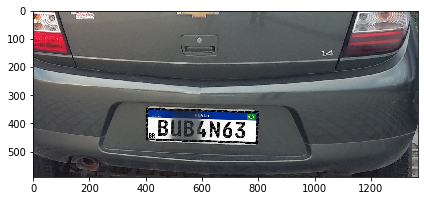

Extracted Characters Method1


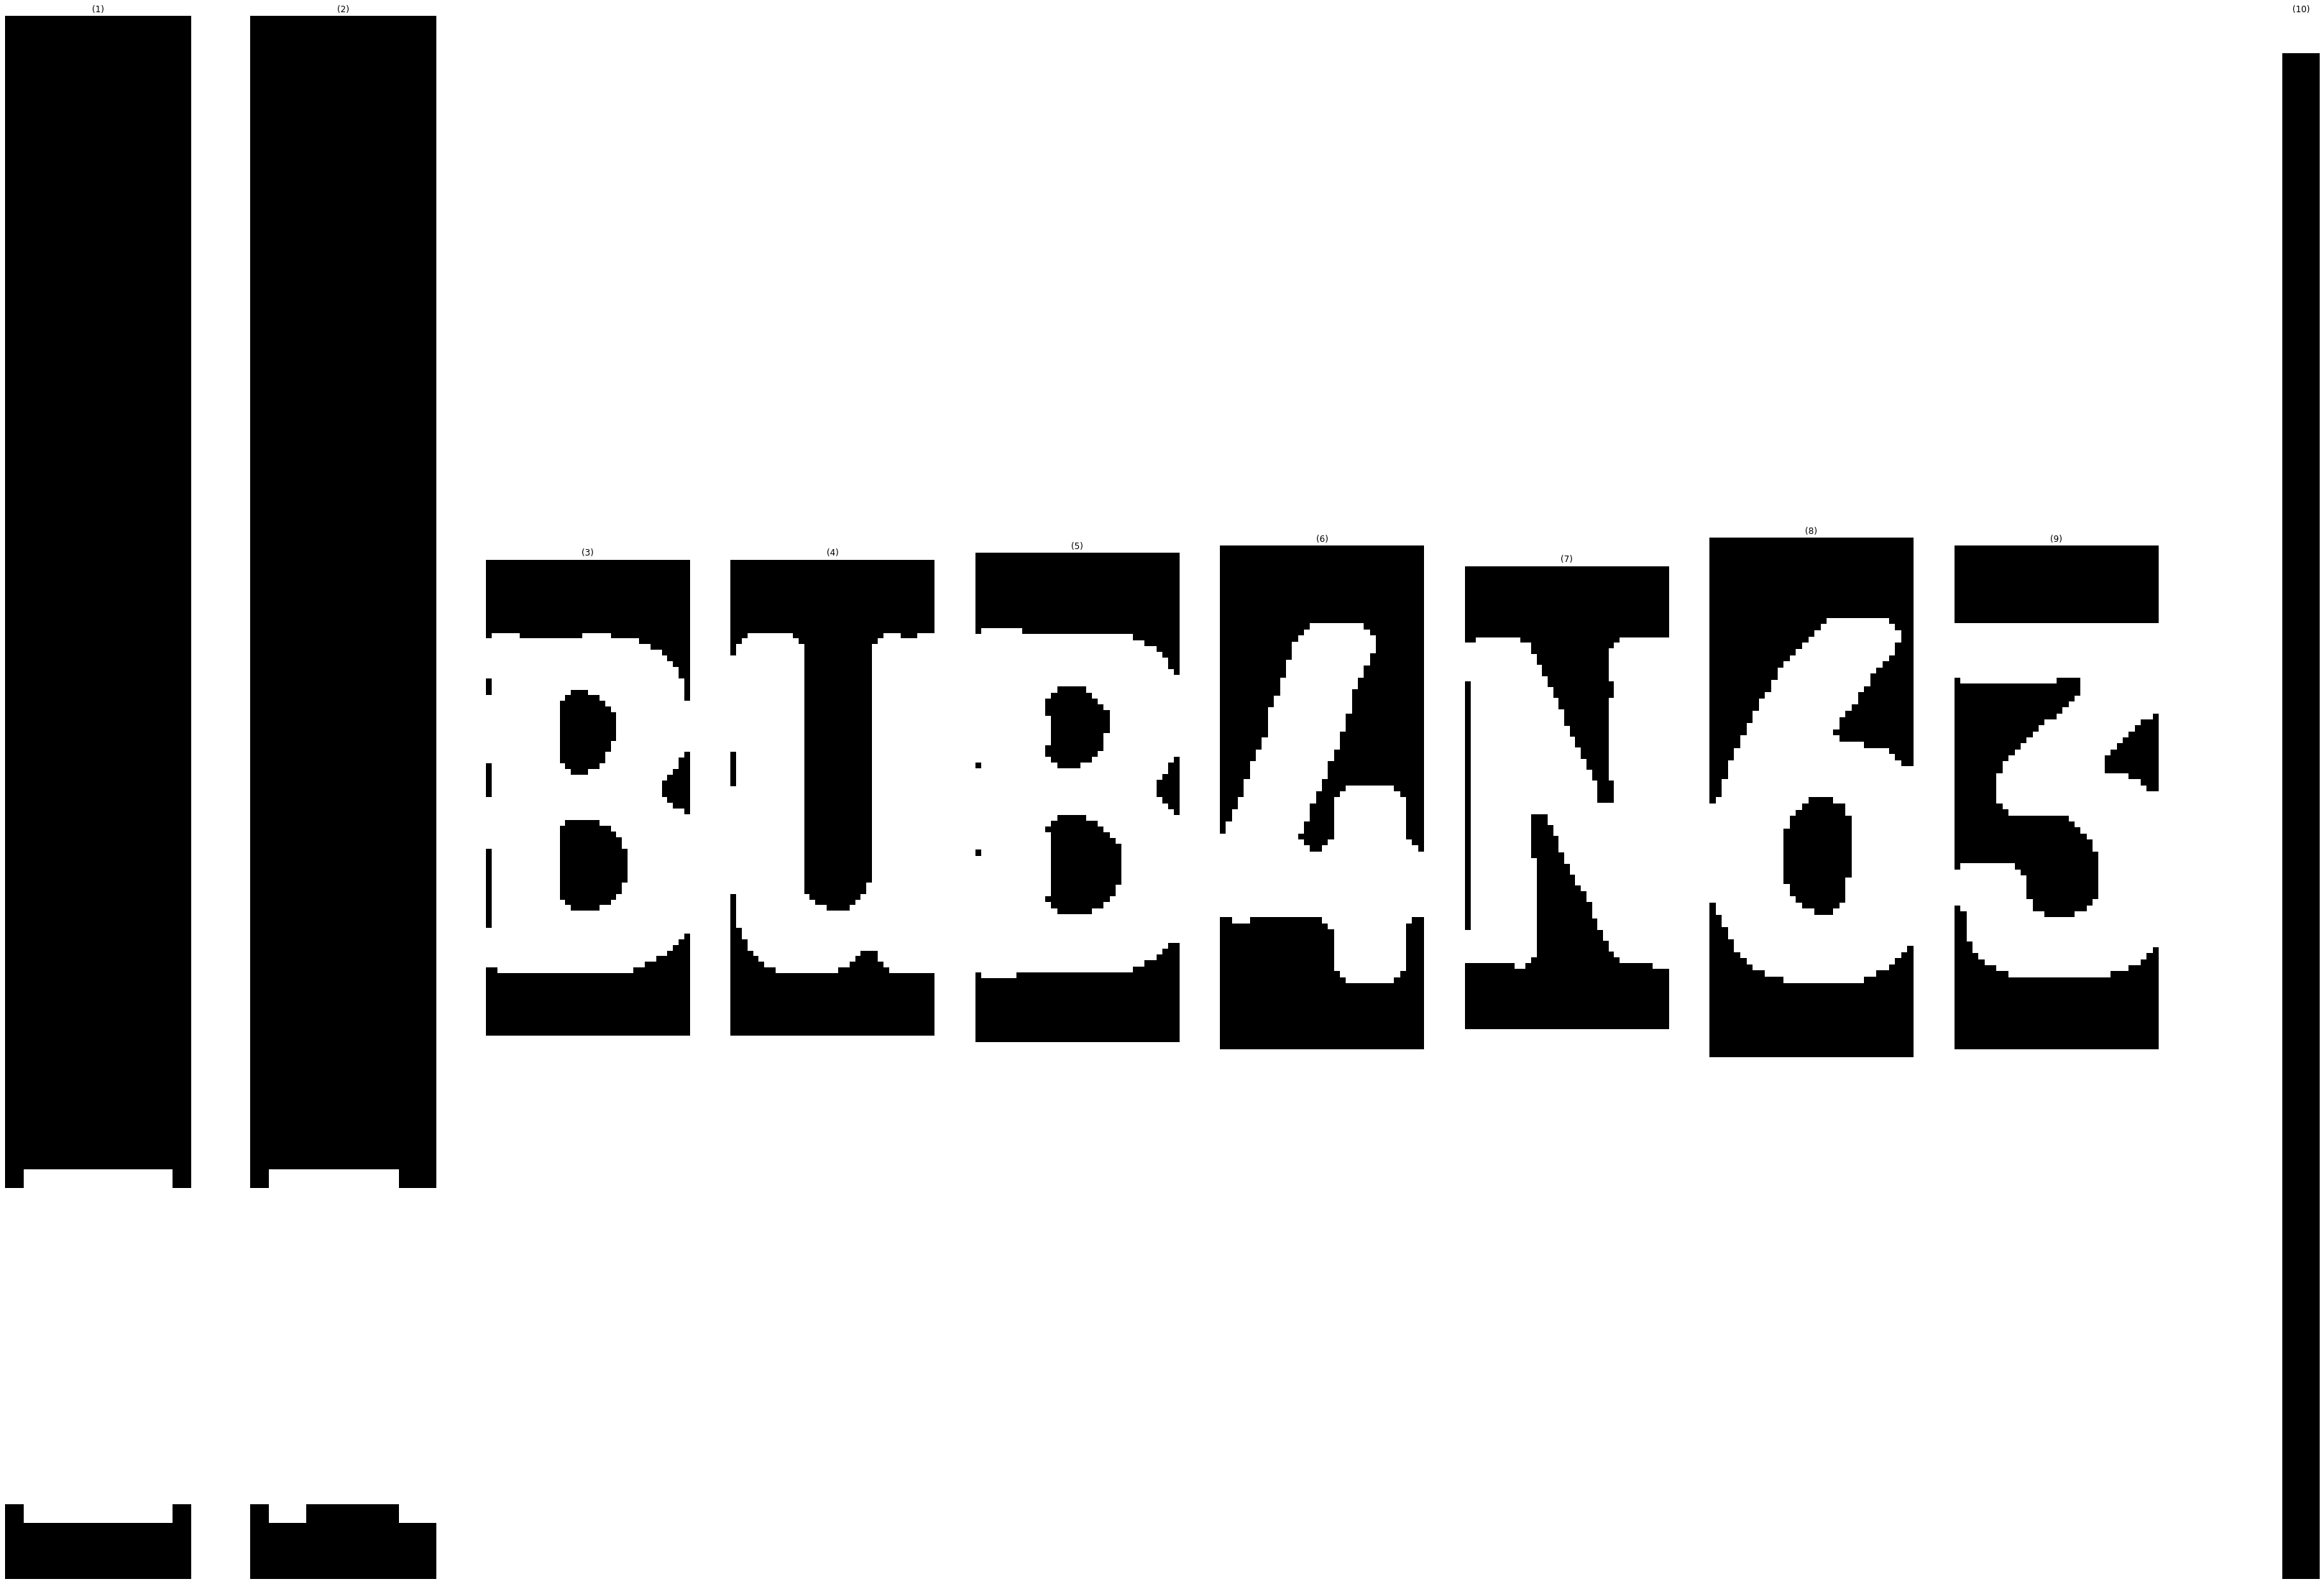

Extracted Characters Method2


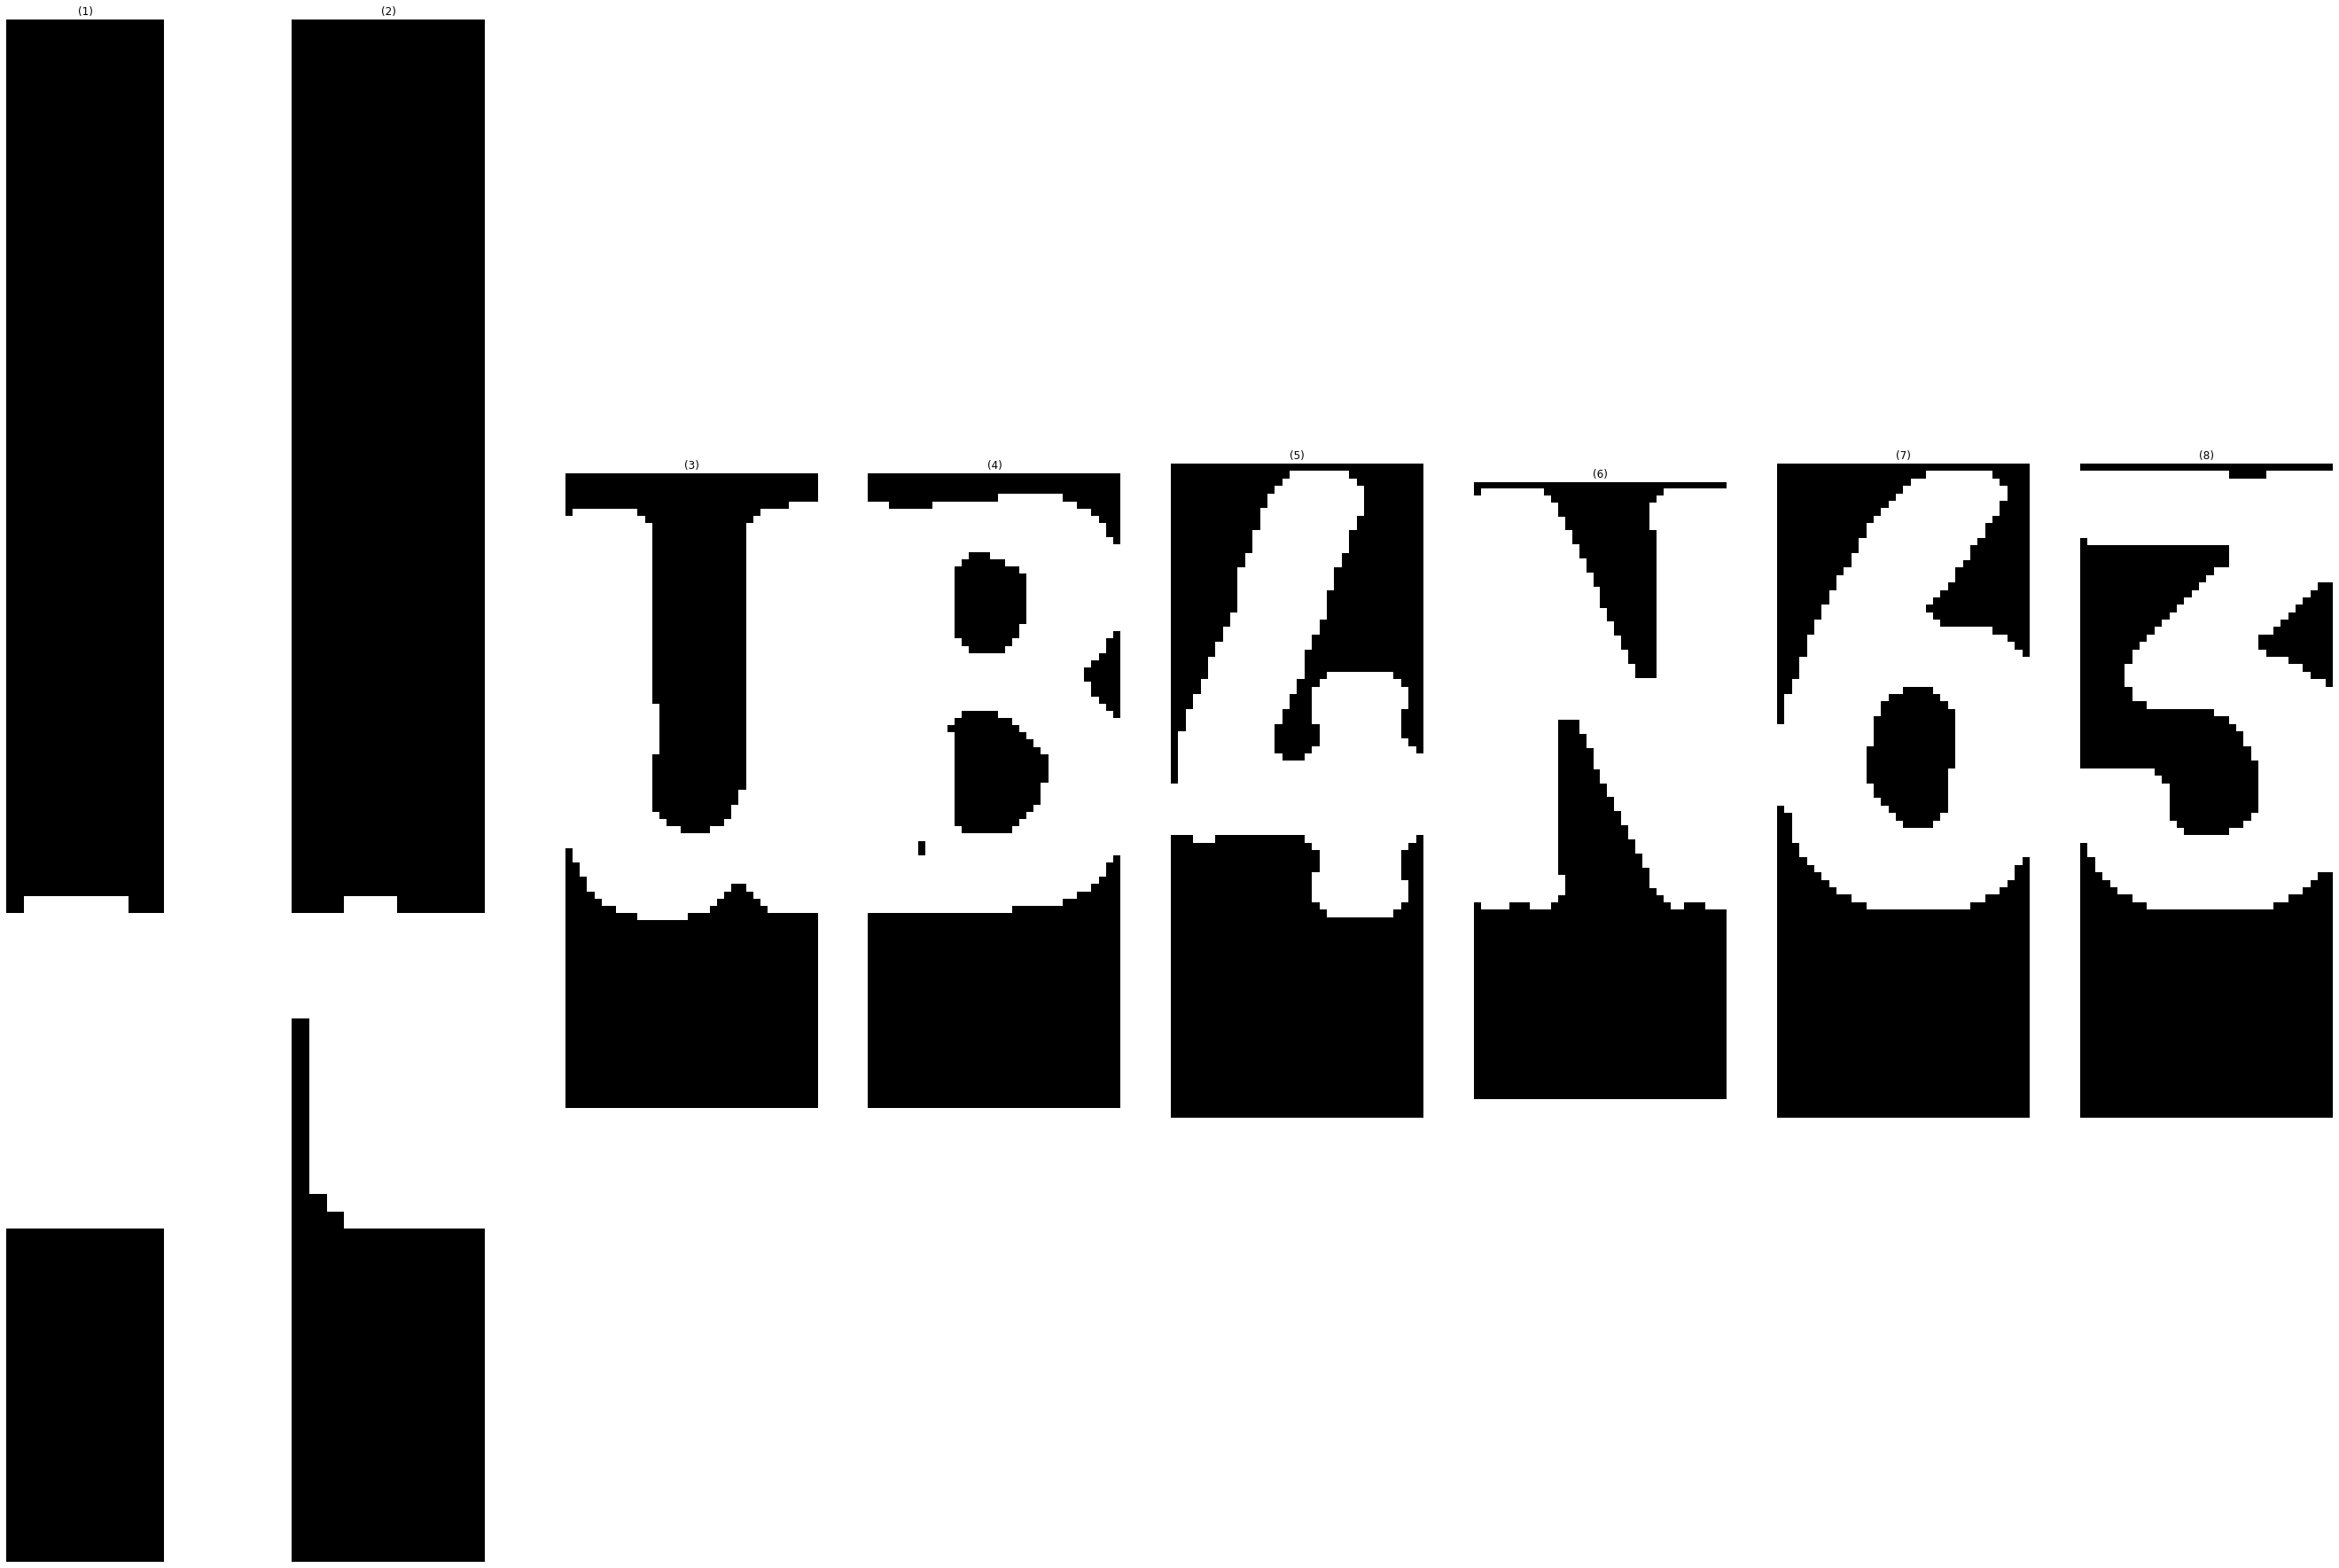

res1: 8U84N65
res4: BTBLN63
res5: U84N6
res8: UBA5


In [158]:
# testOneBrazili2(4)
# testBoth('./DataSet/easy/easy_1.png')
testBoth('./DataSet/Brazil/brasil_37.png')
